##  LangChain LCEL 문서적용

<function matplotlib.pyplot.show(close=None, block=None)>

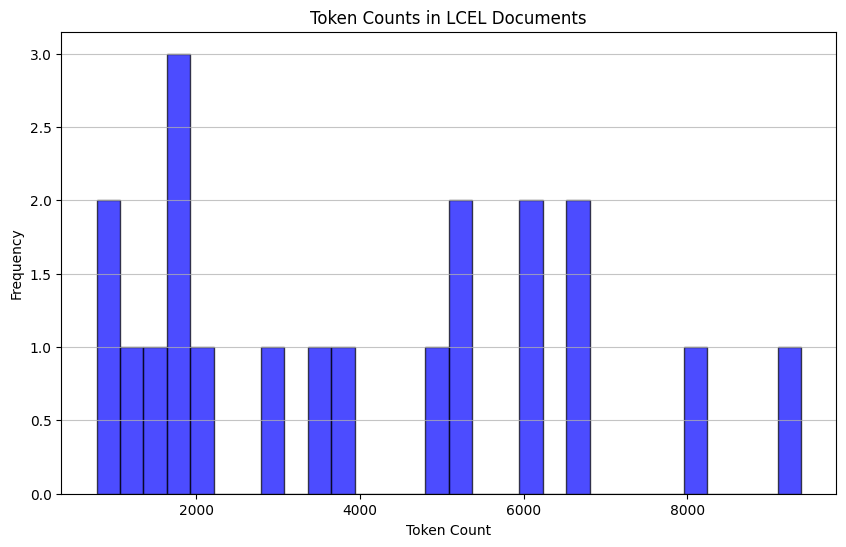

In [60]:
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from bs4 import BeautifulSoup as Soup
import tiktoken
import matplotlib.pyplot as plt


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    # 주어진 문자열에서 토큰의 개수를 반환합니다.
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# LCEL 문서 로드
url = "https://docs.python.org/3/tutorial/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# PydanticOutputParser를 사용한 LCEL 문서 로드 (기본 LCEL 문서 외부)
url = "https://docs.python.org/3/tutorial/datastructures.html"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# Self Query를 사용한 LCEL 문서 로드 (기본 LCEL 문서 외부)
url = "https://docs.python.org/3/tutorial/modules.html"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# 문서 텍스트
docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

# 각 문서에 대한 토큰 수 계산
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# 토큰 수의 히스토그램을 그립니다.
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Token Counts in LCEL Documents")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# 히스토그램을 표시합니다.
plt.show

In [61]:
# 문서 텍스트를 연결합니다.
# 문서를 출처 메타데이터 기준으로 정렬합니다.
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))  # 정렬된 문서를 역순으로 배열합니다.
concatenated_content = "\n\n\n --- \n\n\n".join(
    [
        # 역순으로 배열된 문서의 내용을 연결합니다.
        doc.page_content
        for doc in d_reversed
    ]
)
print(
    "Num tokens in all context: %s"  # 모든 문맥에서의 토큰 수를 출력합니다.
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 80582


In [62]:
# 텍스트 분할을 위한 코드
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000  # 토큰의 청크 크기를 설정합니다.
# 재귀적 문자 텍스트 분할기를 초기화합니다. 토큰 인코더를 사용하여 청크 크기와 중복을 설정합니다.
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(
    concatenated_content
)  # 주어진 텍스트를 분할합니다.

In [63]:
from dotenv import load_dotenv

load_dotenv()

True

In [64]:
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

store = LocalFileStore("./cache/")

# embeddings 인스턴스를 생성합니다.
embd = OpenAIEmbeddings(model="text-embedding-3-small", disallowed_special=())

cached_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embd, store, namespace=embd.model
)

In [65]:
from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.callbacks.base import BaseCallbackHandler


class StreamCallback(BaseCallbackHandler):
    def on_llm_new_token(self, token: str, **kwargs):
        print(token, end="", flush=True)


# ChatOpenAI 모델을 초기화합니다. 모델은 "gpt-4-turbo-preview"를 사용합니다.
model = ChatOpenAI(
    model="gpt-4-turbo-preview",
    temperature=0,
    streaming=True,
    callbacks=[StreamCallback()],
)

# ChatAnthropic 모델을 초기화합니다. 온도는 0으로 설정하고, 모델은 "claude-3-opus-20240229"를 사용합니다.
# model = ChatAnthropic(temperature=0, model="claude-3-opus-20240229")

In [66]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 42  # 재현성을 위한 고정된 시드 값

### --- 위의 인용된 코드에서 주석과 문서화를 추가함 --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    UMAP을 사용하여 임베딩의 전역 차원 축소를 수행합니다.

    매개변수:
    - embeddings: numpy 배열로 된 입력 임베딩.
    - dim: 축소된 공간의 목표 차원.
    - n_neighbors: 선택 사항; 각 점을 고려할 이웃의 수.
                   제공되지 않으면 임베딩 수의 제곱근으로 기본 설정됩니다.
    - metric: UMAP에 사용할 거리 측정 기준.

    반환값:
    - 지정된 차원으로 축소된 임베딩의 numpy 배열.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

In [67]:
def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    임베딩에 대해 지역 차원 축소를 수행합니다. 이는 일반적으로 전역 클러스터링 이후에 사용됩니다.

    매개변수:
    - embeddings: numpy 배열로서의 입력 임베딩.
    - dim: 축소된 공간의 목표 차원 수.
    - num_neighbors: 각 점에 대해 고려할 이웃의 수.
    - metric: UMAP에 사용할 거리 측정 기준.

    반환값:
    - 지정된 차원으로 축소된 임베딩의 numpy 배열.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

In [68]:
def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    가우시안 혼합 모델(Gaussian Mixture Model)을 사용하여 베이지안 정보 기준(BIC)을 통해 최적의 클러스터 수를 결정합니다.

    매개변수:
    - embeddings: numpy 배열로서의 입력 임베딩.
    - max_clusters: 고려할 최대 클러스터 수.
    - random_state: 재현성을 위한 시드.

    반환값:
    - 발견된 최적의 클러스터 수를 나타내는 정수.
    """
    max_clusters = min(
        max_clusters, len(embeddings)
    )  # 최대 클러스터 수와 임베딩의 길이 중 작은 값을 최대 클러스터 수로 설정
    n_clusters = np.arange(1, max_clusters)  # 1부터 최대 클러스터 수까지의 범위를 생성
    bics = []  # BIC 점수를 저장할 리스트
    for n in n_clusters:  # 각 클러스터 수에 대해 반복
        gm = GaussianMixture(
            n_components=n, random_state=random_state
        )  # 가우시안 혼합 모델 초기화
        gm.fit(embeddings)  # 임베딩에 대해 모델 학습
        bics.append(gm.bic(embeddings))  # 학습된 모델의 BIC 점수를 리스트에 추가
    return n_clusters[np.argmin(bics)]  # BIC 점수가 가장 낮은 클러스터 수를 반환

In [69]:
def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    확률 임계값을 기반으로 가우시안 혼합 모델(GMM)을 사용하여 임베딩을 클러스터링합니다.

    매개변수:
    - embeddings: numpy 배열로서의 입력 임베딩.
    - threshold: 임베딩을 클러스터에 할당하기 위한 확률 임계값.
    - random_state: 재현성을 위한 시드.

    반환값:
    - 클러스터 레이블과 결정된 클러스터 수를 포함하는 튜플.
    """
    n_clusters = get_optimal_clusters(embeddings)  # 최적의 클러스터 수를 구합니다.
    # 가우시안 혼합 모델을 초기화합니다.
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)  # 임베딩에 대해 모델을 학습합니다.
    probs = gm.predict_proba(
        embeddings
    )  # 임베딩이 각 클러스터에 속할 확률을 예측합니다.
    # 임계값을 초과하는 확률을 가진 클러스터를 레이블로 선택합니다.
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters  # 레이블과 클러스터 수를 반환합니다.

In [70]:
def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    임베딩에 대해 차원 축소, 가우시안 혼합 모델을 사용한 클러스터링, 각 글로벌 클러스터 내에서의 로컬 클러스터링을 순서대로 수행합니다.

    매개변수:
    - embeddings: numpy 배열로 된 입력 임베딩입니다.
    - dim: UMAP 축소를 위한 목표 차원입니다.
    - threshold: GMM에서 임베딩을 클러스터에 할당하기 위한 확률 임계값입니다.

    반환값:
    - 각 임베딩의 클러스터 ID를 포함하는 numpy 배열의 리스트입니다.
    """
    if len(embeddings) <= dim + 1:
        # 데이터가 충분하지 않을 때 클러스터링을 피합니다.
        return [np.array([0]) for _ in range(len(embeddings))]

    # 글로벌 차원 축소
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # 글로벌 클러스터링
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # 각 글로벌 클러스터를 순회하며 로컬 클러스터링 수행
    for i in range(n_global_clusters):
        # 현재 글로벌 클러스터에 속하는 임베딩 추출
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # 작은 클러스터는 직접 할당으로 처리
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # 로컬 차원 축소 및 클러스터링
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # 로컬 클러스터 ID 할당, 이미 처리된 총 클러스터 수를 조정
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters

In [71]:
def embed(texts):
    # 텍스트 문서 목록에 대한 임베딩을 생성합니다.
    #
    # 이 함수는 `embd` 객체가 존재한다고 가정하며, 이 객체는 텍스트 목록을 받아 그 임베딩을 반환하는 `embed_documents` 메소드를 가지고 있습니다.
    #
    # 매개변수:
    # - texts: List[str], 임베딩할 텍스트 문서의 목록입니다.
    #
    # 반환값:
    # - numpy.ndarray: 주어진 텍스트 문서들에 대한 임베딩 배열입니다.
    text_embeddings = embd.embed_documents(
        texts
    )  # 텍스트 문서들의 임베딩을 생성합니다.
    text_embeddings_np = np.array(text_embeddings)  # 임베딩을 numpy 배열로 변환합니다.
    return text_embeddings_np  # 임베딩된 numpy 배열을 반환합니다.

In [72]:
def embed_cluster_texts(texts):
    """
    텍스트 목록을 임베딩하고 클러스터링하여, 텍스트, 그들의 임베딩, 그리고 클러스터 라벨이 포함된 DataFrame을 반환합니다.

    이 함수는 임베딩 생성과 클러스터링을 단일 단계로 결합합니다. 임베딩에 대해 클러스터링을 수행하는 `perform_clustering` 함수의 사전 정의된 존재를 가정합니다.

    매개변수:
    - texts: List[str], 처리될 텍스트 문서의 목록입니다.

    반환값:
    - pandas.DataFrame: 원본 텍스트, 그들의 임베딩, 그리고 할당된 클러스터 라벨이 포함된 DataFrame입니다.
    """
    text_embeddings_np = embed(texts)  # 임베딩 생성
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # 임베딩에 대해 클러스터링 수행
    df = pd.DataFrame()  # 결과를 저장할 DataFrame 초기화
    df["text"] = texts  # 원본 텍스트 저장
    df["embd"] = list(text_embeddings_np)  # DataFrame에 리스트로 임베딩 저장
    df["cluster"] = cluster_labels  # 클러스터 라벨 저장
    return df

In [73]:
def fmt_txt(df: pd.DataFrame) -> str:
    """
    DataFrame에 있는 텍스트 문서를 단일 문자열로 포맷합니다.

    매개변수:
    - df: 'text' 열에 포맷할 텍스트 문서가 포함된 DataFrame.

    반환값:
    - 모든 텍스트 문서가 특정 구분자로 결합된 단일 문자열.
    """
    unique_txt = df["text"].tolist()  # 'text' 열의 모든 텍스트를 리스트로 변환
    return "--- --- \n --- --- ".join(
        unique_txt
    )  # 텍스트 문서들을 특정 구분자로 결합하여 반환

In [74]:
def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    텍스트 목록에 대해 임베딩, 클러스터링 및 요약을 수행합니다. 이 함수는 먼저 텍스트에 대한 임베딩을 생성하고,
    유사성을 기반으로 클러스터링을 수행한 다음, 클러스터 할당을 확장하여 처리를 용이하게 하고 각 클러스터 내의 내용을 요약합니다.

    매개변수:
    - texts: 처리할 텍스트 문서 목록입니다.
    - level: 처리의 깊이나 세부 사항을 정의할 수 있는 정수 매개변수입니다.

    반환값:
    - 두 개의 데이터프레임을 포함하는 튜플:
      1. 첫 번째 데이터프레임(`df_clusters`)은 원본 텍스트, 그들의 임베딩, 그리고 클러스터 할당을 포함합니다.
      2. 두 번째 데이터프레임(`df_summary`)은 각 클러스터에 대한 요약, 지정된 세부 수준, 그리고 클러스터 식별자를 포함합니다.
    """

    # 텍스트를 임베딩하고 클러스터링하여 'text', 'embd', 'cluster' 열이 있는 데이터프레임을 생성합니다.
    df_clusters = embed_cluster_texts(texts)

    # 클러스터를 쉽게 조작하기 위해 데이터프레임을 확장할 준비를 합니다.
    expanded_list = []

    # 데이터프레임 항목을 문서-클러스터 쌍으로 확장하여 처리를 간단하게 합니다.
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # 확장된 목록에서 새 데이터프레임을 생성합니다.
    expanded_df = pd.DataFrame(expanded_list)

    # 처리를 위해 고유한 클러스터 식별자를 검색합니다.
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # 요약
    template = """여기 LangChain 표현 언어 문서의 하위 집합이 있습니다.
    
    LangChain 표현 언어는 LangChain에서 체인을 구성하는 방법을 제공합니다.
    
    제공된 문서의 자세한 요약을 제공하십시오.
    
    문서:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # 각 클러스터 내의 텍스트를 요약을 위해 포맷팅합니다.
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # 요약, 해당 클러스터 및 레벨을 저장할 데이터프레임을 생성합니다.
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary

In [75]:
def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    지정된 레벨까지 또는 고유 클러스터의 수가 1이 될 때까지 텍스트를 재귀적으로 임베딩, 클러스터링, 요약하여
    각 레벨에서의 결과를 저장합니다.

    매개변수:
    - texts: List[str], 처리할 텍스트들.
    - level: int, 현재 재귀 레벨 (1에서 시작).
    - n_levels: int, 재귀의 최대 깊이.

    반환값:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], 재귀 레벨을 키로 하고 해당 레벨에서의 클러스터 DataFrame과 요약 DataFrame을 포함하는 튜플을 값으로 하는 사전.
    """
    results = {}  # 각 레벨에서의 결과를 저장할 사전

    # 현재 레벨에 대해 임베딩, 클러스터링, 요약 수행
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # 현재 레벨의 결과 저장
    results[level] = (df_clusters, df_summary)

    # 추가 재귀가 가능하고 의미가 있는지 결정
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # 다음 레벨의 재귀 입력 텍스트로 요약 사용
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # 다음 레벨의 결과를 현재 결과 사전에 병합
        results.update(next_level_results)

    return results

In [76]:
len(docs_texts)


20

In [77]:
# 트리 구축
leaf_texts = docs_texts  # 문서 텍스트를 리프 텍스트로 설정
results = recursive_embed_cluster_summarize(
    leaf_texts, level=1, n_levels=3
)  # 재귀적으로 임베딩, 클러스터링 및 요약을 수행하여 결과를 얻음

--Generated 4 clusters--
The provided text is a comprehensive overview of the Python 3.12.4 documentation, specifically focusing on the Python Tutorial section. This tutorial is designed to introduce readers to Python, a powerful and easy-to-learn programming language known for its efficient high-level data structures and simple but effective approach to object-oriented programming. The tutorial covers a wide range of topics, from basic concepts and features of the Python language to more advanced topics such as error handling, executable Python scripts, interactive mode, and customization modules.

Key highlights from the tutorial include:

1. **Introduction to Python**: Python is presented as an ideal language for scripting and rapid application development across various platforms. Its elegant syntax, dynamic typing, and interpreted nature make it suitable for a wide range of applications, from simple scripts to complex applications.

2. **Python's Standard Library and Language Refe

In [78]:
from langchain_community.vectorstores import FAISS

# leaf_texts를 복사하여 all_texts를 초기화합니다.
all_texts = leaf_texts.copy()

# 각 레벨의 요약을 추출하여 all_texts에 추가하기 위해 결과를 순회합니다.
for level in sorted(results.keys()):
    # 현재 레벨의 DataFrame에서 요약을 추출합니다.
    summaries = results[level][1]["summaries"].tolist()
    # 현재 레벨의 요약을 all_texts에 추가합니다.
    all_texts.extend(summaries)

# 이제 all_texts를 사용하여 FAISS vectorstore를 구축합니다.
vectorstore = FAISS.from_texts(texts=all_texts, embedding=embd)

In [79]:
import os

DB_INDEX = "RAPTOR"

# 로컬에 FAISS DB 인덱스가 이미 존재하는지 확인하고, 그렇다면 로드하여 vectorstore와 병합한 후 저장합니다.
if os.path.exists(DB_INDEX):
    local_index = FAISS.load_local(DB_INDEX, embd)
    local_index.merge_from(vectorstore)
    local_index.save_local(DB_INDEX)
else:
    vectorstore.save_local(folder_path=DB_INDEX)

In [80]:
# retriever 생성
retriever = vectorstore.as_retriever()

In [81]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# 프롬프트 생성
prompt = hub.pull("rlm/rag-prompt")

# 문서 포스트 프로세싱


def format_docs(docs):
    # 문서의 페이지 내용을 이어붙여 반환합니다.
    return "\n\n".join(doc.page_content for doc in docs)


# RAG 체인 정의
rag_chain = (
    # 검색 결과를 포맷팅하고 질문을 처리합니다.
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt  # 프롬프트를 적용합니다.
    | model  # 모델을 적용합니다.
    | StrOutputParser()  # 문자열 출력 파서를 적용합니다.
)

In [82]:
# 추상적인 질문 실행
_ = rag_chain.invoke("전체 문서의 핵심 주제에 대해 설명해주세요.")

이 문서는 Python 3.12.4의 Python Tutorial 섹션에 대한 포괄적인 개요를 제공하며, Python 프로그래밍 언어의 기본 개념과 기능부터 고급 주제에 이르기까지 다양한 주제를 다룹니다. 초보자가 Python 프로그래밍을 시작하는 데 필요한 포괄적인 가이드를 제공하며, 경험 많은 개발자들이 언어와 그 생태계에 대한 더 깊은 이해를 추구할 수 있는 참조 자료로도 사용됩니다. 주요 내용으로는 Python 소개, 표준 라이브러리와 언어 참조, 대화형 Python 인터프리터 사용, 실행 가능한 Python 스크립트, 가상 환경 및 패키지, 오류 처리 및 예외, Python 커스터마이징 및 확장, 대화형 입력 편집 및 히스토리 대체 등이 포함됩니다.

In [83]:
# Low Level 질문 실행
_ = rag_chain.invoke("기초 파이썬 코드를 작성해주세요.")

기초 파이썬 코드를 작성하는 예시는 다음과 같습니다:

```python
print("Hello, World!")
```

이 코드는 "Hello, World!"라는 문장을 화면에 출력합니다.